In [2]:
import gymnasium as gym
import numpy as np
import pygame
from utils import Monitor
from gymnasium import spaces
from stable_baselines3 import PPO

In [11]:
class SimpleClimateBiasCorrectionEnv(gym.Env):
    """
    A gym environment for a simple climate bias correction problem.

    The environment simulates a single temperature variable that evolves over time, with a goal
    to learn a heating increment (`u`) which minimizes the size of an analysis bias correction term.

    Attributes:
        min_temperature (float): Minimum normalized temperature.
        max_temperature (float): Maximum normalized temperature.
        max_heating_rate (float): Maximum heating rate.
        dt (float): Time step in minutes.
        count (float): Counter for internal use.
        viewer: For rendering the environment.
        action_space (gym.spaces.Box): The space of possible actions (heating rates).
        observation_space (gym.spaces.Box): The space of possible states (temperatures).
        np_random: Random number generator for the environment.

    Author:
        Mark Webb, Met Office
        Email: mark.webb@metoffice.gov.uk
    """

    def __init__(self):
        self.min_temperature = 0.0
        self.max_temperature = 1.0
        self.max_heating_rate = 1.0
        self.dt = 1.0  # Time step (minutes)
        self.count = 0.0
        self.screen = None
        self.clock = None
        self.max_steps=2000

        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-self.max_heating_rate,
            high=self.max_heating_rate,
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(
            low=np.array([self.min_temperature], dtype=np.float32),
            high=np.array([self.max_temperature], dtype=np.float32),
            dtype=np.float32,
        )

    def step(self, u):
        """
        Performs one step in the environment using the action `u`.

        Args:
            u (float): The action, representing a heating increment.

        Returns:
            tuple: A tuple containing the new observation, the reward, whether the episode is done,
                   and additional information.
        """
        current_temperature = self.state[0]
        self.current_step+=1

        # Clip action to the allowed range
        u = np.clip(u, -self.max_heating_rate, self.max_heating_rate)[0]

        # Calculate new temperature
        observed_temperature = (371.75 - 273.15) / 100
        physics_temperature = (380 - 273.15) / 100
        division_constant = physics_temperature - observed_temperature

        new_temperature = current_temperature + u
        relaxation = (
            (physics_temperature - current_temperature)
            * 0.2
            / division_constant
        )
        new_temperature += relaxation

        bias_correction = (
            (observed_temperature - new_temperature) * 0.1 / division_constant
        )
        new_temperature += bias_correction

        # Calculate cost (negative reward)
        costs = bias_correction**2
        new_temperature = np.clip(
            new_temperature, self.min_temperature, self.max_temperature
        )

        self.state = np.array([new_temperature])
        done = self.current_step >= self.max_steps

        self.reward=-costs
        return self._get_obs(), self.reward, done, False, self._get_info()

    def reset(self, seed=None, options=None):
        """
        Resets the environment to an initial state.

        Returns:
            np.array: The initial observation.
        """
        super().reset(seed=seed)
        self.current_step=0
        self.state = np.array([(300 - 273.15) / 100])  # Starting temperature

        return self._get_obs(), self._get_info()

    def _get_info(self):
        return {"_": None}

    def _get_obs(self):
        """
        Returns the current observation (state).

        Returns:
            np.array: The current observation.
        """
        temperature = self.state[0]
        return np.array([temperature], dtype=np.float32)

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
            self.clock = None

In [ ]:
env = SimpleClimateBiasCorrectionEnv()
model = PPO("MlpPolicy", env, verbose=1)
callback=Monitor(verbose=0,save_to_csv=False)
model.learn(total_timesteps=100000,callback=callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\hamed\AppData\Local\Programs\Python\Python312\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward` for environment variables or `env.get_wrapper_attr('reward')` that will search the reminding wrappers.
  logger.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2e+03     |
|    ep_rew_mean     | -1.92e+03 |
| time/              |           |
|    fps             | 974       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2e+03       |
|    ep_rew_mean          | -1.76e+03   |
| time/                   |             |
|    fps                  | 694         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017604295 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | 6.85e-05    |
|    learning_rate  

In [26]:
data=dict()
x=list(np.arange(0,env.get_total_steps(),env.get_episode_lengths()[0]))
data["total_steps"]=env.get_total_steps()
data["episode_length"]=env.get_episode_lengths()[0]
data["timesteps"]=x
#data["reward"]=env.get_episode_rewards()
data["reward"]=[-i for i in env.get_episode_rewards()]

In [27]:
import pickle
with open("data_climate_ppo.pkl", "wb") as file:
    pickle.dump(data, file)

In [28]:
import pickle
with open("data_climate_ppo.pkl", "rb") as file:
    data_ppo = pickle.load(file)

In [8]:
model=PPO.load("climate_500k")
obs = env.reset()[0]
n_steps = 20000
rewards=[]
print(obs)
for step in range(n_steps):
    action, _ = model.predict(obs)
    
    obs, reward, _, _, _ = env.step(action)
    rewards.append(-reward)

[0.2685]


RuntimeError: Tried to step environment that needs reset

In [ ]:
obs = env.reset()[0]
n_steps = 10000
rewardss=[]
states=[]
rewards=0
for step in range(n_steps):
    action = model.predict(obs)[0]
    states.append(obs[0]*100+273.15)
    obs, reward, done, _, _ = env.step(action)
    rewards-=reward
    if done:
        obs = env.reset()[0]
        rewardss.append(rewards)
        rewards=0
    

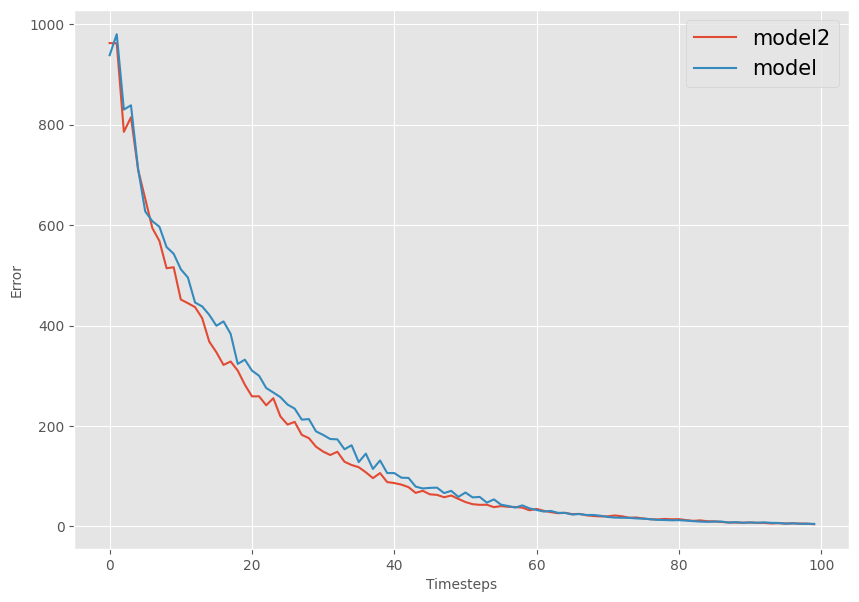

In [24]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
fig,ax=plt.subplots()

#ax.plot(data["reward"],label="model")
#ax.plot(rewardss,label="random")
x=0
ax.plot(-jnp.array(callback2.episode_rewards),label="model2")
ax.plot(-jnp.array(callback.episode_rewards),label="model")
plt.xlabel('Timesteps',fontsize=10)
plt.ylabel('Error',fontsize=10)
ax.legend(fontsize=15)
fig.set_size_inches(10, 7, forward=True)

plt.show()

In [10]:
len((callback.episode_rewards))

100